In [1]:
import os,sys
currentdir = os.path.dirname(os.path.abspath('./'))
parentdir = os.path.dirname(currentdir)
sys.path.append(currentdir)
# import thbbanalysis.histogramming as hist
# from thbbanalysis.common import tools
# from thbbanalysis.common.branches import *
# from thbbanalysis.common.selection import *
# from thbbanalysis.histogramming.classes import *
from thbbanalysis.common.user_tools import *
# from thbbanalysis.common.logger import *
import dask
import time
import glob
from thbbanalysis.common import tools
import boost_histogram as bh

In [2]:
general_settings = {}
general_settings['OutDir'] = './TestDask/Output/'
general_settings['inDir']  = '../thbb_boosted_outputs_2/'
general_settings['inFormat']  = 'h5'

def get_inputs(sample: str):
    '''
    Method to get a list of files to read in. This assumes all files
    are named sample_chunk*
    Args:
        cfg: Config object carrying all info provided by user in config file
        sample: Name of the sample being processed
    Return
        files: A list of files to read
    '''
    indirs = [general_settings['inDir']]
    ext = general_settings['inFormat']
    files = [infile for indir in indirs for infile in glob.glob(f"{indir}/{sample}_chunk*{ext}")]
    if len(files) == 0:
        exit(1)
    return files

In [10]:
from dask.distributed import Client
from copy import copy
client = Client(n_workers = 5, threads_per_worker = 1)  # start distributed scheduler locally.
client

/opt/anaconda3/envs/pythium/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58536 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:58537' processes=5 threads=5, memory=32.00 GiB>

In [18]:

hists = {}
files = get_inputs('ttbar')

@dask.delayed
def test(jet_pt):
    jets_pt = copy(jet_pt)
    jets_pt = mask(jets_pt, count_jagged(jets_pt, axis=1)>=1)
    return jets_pt[:, 0]*1e-3

@dask.delayed
def make_and_fill(data, axes):
    h = bh.Histogram(*axes, storage=bh.storage.Weight())
    h.fill(data)
    return h 

batch_size = 4
results = []
for i in range(0, len(files), batch_size):
    batch = []
    for j, file in enumerate(files[i:i+batch_size]):
        print(f"Reading in data from file {i+j+1}/{len(files)} ...")
        data = dask.delayed(tools.h5py_to_ak)(file)[0]['ttbar']['nominal_Loose']
        pt = data['jet_pt']
        new_pt = test(pt)
        new_pt = new_pt.to_numpy()
        new_pt= new_pt.compressed()
        for k in range(100):
            axes = (bh.axis.Regular(25, 0, 250), )
            h = make_and_fill(new_pt, axes)
            batch.append(h)
    results.append(batch)

Reading in data from file 1/20 ...
Reading in data from file 2/20 ...
Reading in data from file 3/20 ...
Reading in data from file 4/20 ...
Reading in data from file 5/20 ...
Reading in data from file 6/20 ...
Reading in data from file 7/20 ...
Reading in data from file 8/20 ...
Reading in data from file 9/20 ...
Reading in data from file 10/20 ...
Reading in data from file 11/20 ...
Reading in data from file 12/20 ...
Reading in data from file 13/20 ...
Reading in data from file 14/20 ...
Reading in data from file 15/20 ...
Reading in data from file 16/20 ...
Reading in data from file 17/20 ...
Reading in data from file 18/20 ...
Reading in data from file 19/20 ...
Reading in data from file 20/20 ...


In [19]:
%time dask.compute(*results)

CPU times: user 4.64 s, sys: 678 ms, total: 5.31 s
Wall time: 14.4 s


([Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=1.70433e+06, variance=1.70433e+06) (WeightedSum(value=1.78232e+06, variance=1.78232e+06) with flow),
  Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=1.70433e+06, variance=1.70433e+06) (WeightedSum(value=1.78232e+06, variance=1.78232e+06) with flow),
  Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=1.70433e+06, variance=1.70433e+06) (WeightedSum(value=1.78232e+06, variance=1.78232e+06) with flow),
  Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=1.70433e+06, variance=1.70433e+06) (WeightedSum(value=1.78232e+06, variance=1.78232e+06) with flow),
  Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=1.70433e+06, variance=1.70433e+06) (WeightedSum(value=1.78232e+06, variance=1.78232e+06) with flow),
  Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=1.70433e+06, variance=1.70433e+06) (Wei

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.412402 to fit


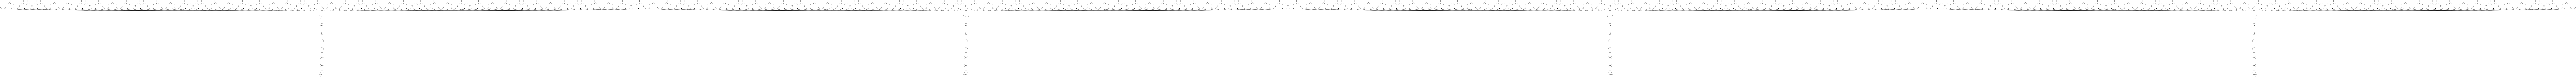

In [20]:
dask.visualize(results[0])

In [21]:
%%time
def test(jet_pt):
    jets_pt = copy(jet_pt)
    jets_pt = mask(jets_pt, count_jagged(jets_pt, axis=1)>=1)
    return jets_pt[:, 0]*1e-3

def make_and_fill(data, axes):
    h = bh.Histogram(*axes, storage=bh.storage.Weight())
    h.fill(data)
    return h 

batch_size = 4
results = []
for i in range(0, len(files), batch_size):
    batch = []
    for j, file in enumerate(files[i:i+batch_size]):
        print(f"Reading in data from file {i+j+1}/{len(files)} ...")
        data = tools.h5py_to_ak(file)[0]['ttbar']['nominal_Loose']
        pt = data['jet_pt']
        new_pt = test(pt)
        new_pt = new_pt.to_numpy()
        new_pt = new_pt.compressed()
        
        for k in range(100):
            axes = (bh.axis.Regular(25, 0, 250), )
            h = make_and_fill(new_pt, axes)
            batch.append(h)
    results.append(batch)

Reading in data from file 1/20 ...
Reading in data from file 2/20 ...
Reading in data from file 3/20 ...
Reading in data from file 4/20 ...
Reading in data from file 5/20 ...
Reading in data from file 6/20 ...
Reading in data from file 7/20 ...
Reading in data from file 8/20 ...
Reading in data from file 9/20 ...
Reading in data from file 10/20 ...
Reading in data from file 11/20 ...
Reading in data from file 12/20 ...
Reading in data from file 13/20 ...
Reading in data from file 14/20 ...
Reading in data from file 15/20 ...
Reading in data from file 16/20 ...
Reading in data from file 17/20 ...
Reading in data from file 18/20 ...
Reading in data from file 19/20 ...
Reading in data from file 20/20 ...
CPU times: user 14.7 s, sys: 6.01 s, total: 20.8 s
Wall time: 21.7 s
